In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"

VIS_CONF_THRESHOLD = 0.9


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [ ]:
import matplotlib.pyplot as plt
import torch
from posingpixels.cotracker import CoMeshTracker
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from pytorch3d.ops.perspective_n_points import efficient_pnp
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks


from posingpixels.utils.cotracker import unscale_by_crop

from posingpixels.utils.evaluation import compute_add_metrics

from posingpixels.pointselector import SelectMostConfidentView, SelectMostConfidentPoint
from posingpixels.utils.evaluation import compute_tapvid_metrics


import importlib
from pytorch3d.transforms import rotation_6d_to_matrix, matrix_to_rotation_6d

from typing import Optional
import mediapy
from posingpixels.pnp import (
    OldGradientBatchPnP,
    PnPSolver,
    render_train_model,
)
from posingpixels.utils.geometry import (
    apply_pose_to_points_batch,
    render_points_in_2d_batch,
)
from posingpixels.visualization import overlay_bounding_box_on_video


import mediapy as media
import numpy as np
from PIL import Image






device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
dataset = YCBinEOATDataset(video_dir, obj_dir)
tracker = CoMeshTracker(
    dataset,
    # support_grid=10,
    offline=False,
    # crop=False,
    # visible_background=True,
    # downcast=True,
    # better_initialization=False,
    # limit=100,
    # interpolation_steps=80,
    axis_rotation_steps=40,
    final_interpolation_steps=40,
    query_frames=[0, 10, 20, 30],
    device=device,
)

In [4]:
pred_tracks, pred_visibility, pred_confidence = tracker()

Creating init video


Preparing images for CoTracker: 100%|██████████| 817/817 [00:18<00:00, 45.08it/s]
Processing batches: 103it [00:49,  2.06it/s]                         


In [5]:
video = load_video_images(tracker.cotracker_input_dir, limit=tracker.limit)
init_video = load_video_images(
    tracker.init_video_dir, limit=tracker.limit, file_type="jpg"
)
video_original = load_video_images(tracker.dataset.video_rgb_dir, limit=tracker.limit)

In [6]:
visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
)

gt_tracks, gt_visibility = get_gt_tracks(tracker)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="gt_video",
    threshold=VIS_CONF_THRESHOLD,
)
pred_tracks_original = unscale_by_crop(
    pred_tracks[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

full_video = torch.cat([init_video, video_original], dim=1)[:, : tracker.limit]
visualize_results(
    full_video,
    pred_tracks_original,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="original",
    threshold=VIS_CONF_THRESHOLD,
)

gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker, crop=False)
visualize_results(
    full_video,
    torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility_original).to(device))
    .unsqueeze(0)
    .float(),
    tracker_result_video,
    num_of_main_queries=tracker.num_query_points,
    filename="gt_original",
    threshold=VIS_CONF_THRESHOLD,
)

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/original.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_original.mp4


In [7]:
%load_ext autoreload
%autoreload 2

In [ ]:
tensor_query_to_point = torch.tensor(tracker.query_to_point, device=device)
true_indexes = torch.nonzero(tensor_query_to_point)
query_lengths = torch.tensor(tracker.queries_sizes, device=device)

# point_selector = SelectMostConfidentPoint(
#     tracker.num_object_points, true_indexes, query_lengths
# )
point_selector = SelectMostConfidentView(
    tracker.num_object_points, true_indexes, query_lengths
)

best_coords, best_vis, best_conf, best_indices = point_selector.query_to_point(
    pred_tracks[0],
    pred_visibility[0],
    pred_confidence[0],
    pred_visibility[0] * pred_confidence[0],
)
best_coords = best_coords.unsqueeze(0)
best_vis = best_vis.unsqueeze(0)
best_conf = best_conf.unsqueeze(0)

best_coords_original = unscale_by_crop(
    best_coords[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

/home/joao/Documents/repositories/GSPose/posingpixels/pointselector.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(queries_lengths),


In [9]:
query_points = tracker.query_2d_points[np.newaxis, : tracker.num_object_points]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = best_vis.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = best_coords.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = best_conf.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = VIS_CONF_THRESHOLD
evaluation_points = pred_confidence_ * pred_visibility_ > threshold
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode="first",
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

(1, 202, 3)
(1, 202, 817)
(1, 202, 817, 2)
(1, 202, 817)
(1, 202, 817, 2)
(1, 202, 817)
occlusion_accuracy [0.95943739]
average_jaccard [0.31520614]
average_pts_within_thresh [0.44387574]
pts_within_1 [0.23143589]
jaccard_1 [0.1278057]
pts_within_2 [0.25010552]
jaccard_2 [0.13955442]
pts_within_4 [0.31407749]
jaccard_4 [0.18173677]
pts_within_8 [0.5326402]
jaccard_8 [0.3528266]
pts_within_16 [0.89111962]
jaccard_16 [0.77410721]
dict_keys(['occlusion_accuracy_over_time', 'occlusion_accuracy', 'time_pts_within_1', 'per_point_pts_within_1', 'pts_within_1', 'time_jaccard_1', 'per_point_jaccard_1', 'jaccard_1', 'time_pts_within_2', 'per_point_pts_within_2', 'pts_within_2', 'time_jaccard_2', 'per_point_jaccard_2', 'jaccard_2', 'time_pts_within_4', 'per_point_pts_within_4', 'pts_within_4', 'time_jaccard_4', 'per_point_jaccard_4', 'jaccard_4', 'time_pts_within_8', 'per_point_pts_within_8', 'pts_within_8', 'time_jaccard_8', 'per_point_jaccard_8', 'jaccard_8', 'time_pts_within_16', 'per_point_pt

/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:139: RuntimeWarning: invalid value encountered in divide
  occ_acc_ = np.sum(np.equal(pred_occluded, gt_occluded) & evaluation_points, axis=1) / np.sum(evaluation_points, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:177: RuntimeWarning: invalid value encountered in divide
  frac_correct_time_ = np.sum(count_correct_, axis=1) / np.sum(count_visible_points_, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:206: RuntimeWarning: invalid value encountered in divide
  jaccard_time_ = np.sum(true_positives_, axis=1) / (np.sum(gt_positives_ + false_positives_, axis=1))


Text(0.5, 1.0, 'Number of points considered per time step with visibility * confidence > 0.9')

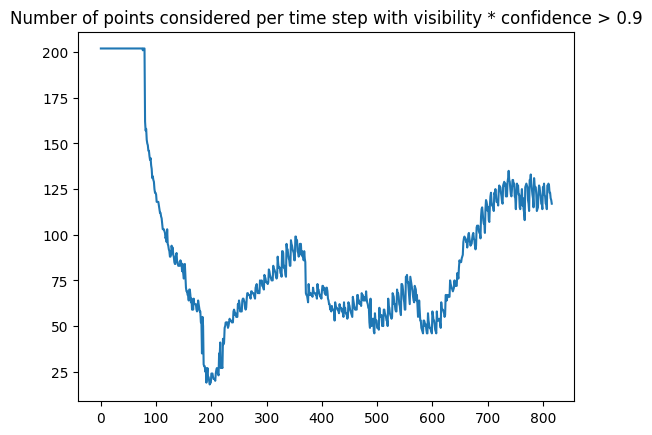

In [10]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(
    f"Number of points considered per time step with visibility * confidence > {threshold}"
)

Text(0, 0.5, 'Value')

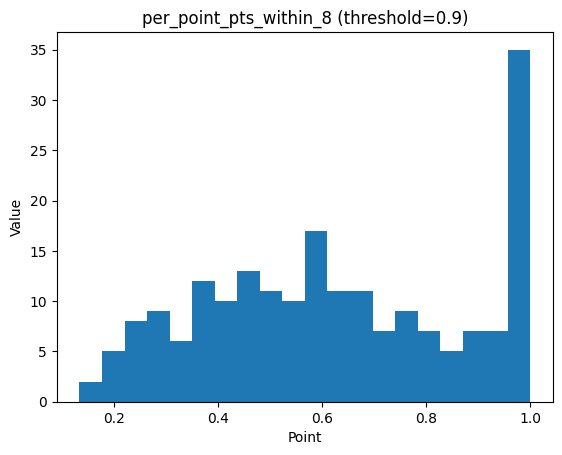

In [11]:
metric_name = "per_point_pts_within_8"
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if "time" in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(
    tracker.interpolation_steps, color="r", linestyle="--"
) if "time" in metric_name else None
plt.title(f"{metric_name} (threshold={threshold})")
plt.xlabel("Frame" if "time" in metric_name else "Point")
plt.ylabel("Value")

In [ ]:
def ransac_pnp(
    points_3d: torch.Tensor,
    points_2d: torch.Tensor,
    K: torch.Tensor,
    image_size: torch.Tensor,
    device: torch.device,
    weights: Optional[torch.Tensor] = None,
    num_iterations: int = 100,
    inlier_threshold: float = 5.0,
):
    if len(points_2d.shape) == 2:
        points_2d = points_2d.clone().unsqueeze(0)
    B, N, _ = points_2d.shape
    if len(points_3d.shape) == 2:
        points_3d = points_3d.clone().unsqueeze(0).repeat(B, 1, 1)
    if len(image_size.shape) == 1:
        image_size = image_size.unsqueeze(0).repeat(B, 1)
    if weights is not None and len(weights.shape) == 1:
        weights = weights.clone().unsqueeze(0).repeat(B, 1)
    if len(K.shape) == 2:
        K = K[:3, :3].clone().unsqueeze(0).repeat(B, 1, 1)

    p3d = points_3d
    p2d_h = torch.cat(
        (points_2d[..., :2], torch.ones(B, N, 1, device=device).to(device)), dim=-1
    )
    # Flip focal length (because of the way pytorch3d is implemented)
    # K[:, 0, 0] = -K[:, 0, 0]; K[:, 1, 1] = -K[:, 1, 1]
    p_inv = torch.inverse(K).transpose(1, 2)
    p2d_uncal = torch.matmul(p2d_h, p_inv)[..., :2]

    # For each batch, get the indices of the most confident points sorted by confidence
    # This is to ensure that the most confident points are used for the PnP
    if weights is not None:
        sorted_indices = torch.argsort(weights, descending=True)
        sorted_confidence = torch.gather(weights, 1, sorted_indices)
    else:
        sorted_indices = torch.arange(N, device=device).unsqueeze(0).repeat(B, 1)
        sorted_confidence = torch.ones_like(sorted_indices, device=device)

    best_rotation = torch.eye(3, device=device).unsqueeze(0).repeat(B, 1, 1)
    best_translation = torch.zeros(3, device=device).unsqueeze(0).repeat(B, 1)
    best_score = -torch.ones(B, device=device) * 1e6

    subset_size = min(10, N)
    batch_indices = (
        torch.arange(B, device=device).unsqueeze(1).repeat(1, subset_size).flatten()
    )
    for _ in range(num_iterations):
        # Get a random subset of the points
        # Do weighted random sampling
        subset_indices = torch.multinomial(sorted_confidence, subset_size)
        subset_indices = torch.gather(sorted_indices, 1, subset_indices)
        # iteration_weights = torch.zeros_like(weights)
        # iteration_weights[batch_indices, subset_indices] = weights[batch_indices, subset_indices]
        p3d_subset = torch.gather(p3d, 1, subset_indices.unsqueeze(-1).repeat(1, 1, 3))
        p2d_subset = torch.gather(
            p2d_uncal, 1, subset_indices.unsqueeze(-1).repeat(1, 1, 2)
        )

        transform = efficient_pnp(p3d_subset, p2d_subset)
        projected = PnPSolver.render_points(
            PnPSolver.pose_points(x, transform.R.transpose(1, 2), transform.T), K
        )[..., :2]
        error = torch.mean(weights * torch.norm(projected - points_2d, dim=-1), dim=-1)
        score = -error
        improved = score > best_score
        best_score[improved] = score[improved]
        best_rotation[improved] = transform.R[improved]
        best_translation[improved] = transform.T[improved]

    poses = torch.eye(4).to(device).unsqueeze(0).repeat(B, 1, 1)
    poses[:, :3, :3] = best_rotation.transpose(1, 2)
    poses[:, :3, 3] = best_translation

    return poses, best_score


def solve_pnp(
    points_3d: torch.Tensor,
    points_2d: torch.Tensor,
    K: torch.Tensor,
    image_size: torch.Tensor,
    device: torch.device,
    weights: Optional[torch.Tensor] = None,
):
    if len(points_2d.shape) == 2:
        points_2d = points_2d.clone().unsqueeze(0)
    B, N, _ = points_2d.shape
    if len(points_3d.shape) == 2:
        points_3d = points_3d.clone().unsqueeze(0).repeat(B, 1, 1)
    if len(image_size.shape) == 1:
        image_size = image_size.unsqueeze(0).repeat(B, 1)
    if weights is not None and len(weights.shape) == 1:
        weights = weights.clone().unsqueeze(0).repeat(B, 1)
    if len(K.shape) == 2:
        K = K[:3, :3].clone().unsqueeze(0).repeat(B, 1, 1)

    p3d = points_3d
    p2d_h = torch.cat(
        (points_2d[..., :2], torch.ones(B, N, 1, device=device).to(device)), dim=-1
    )
    # Flip focal length (because of the way pytorch3d is implemented)
    # K[:, 0, 0] = -K[:, 0, 0]; K[:, 1, 1] = -K[:, 1, 1]
    p_inv = torch.inverse(K).transpose(1, 2)
    p2d_uncal = torch.matmul(p2d_h, p_inv)
    transform = efficient_pnp(p3d, p2d_uncal[..., :2], weights)

    poses = torch.eye(4).to(device).unsqueeze(0).repeat(B, 1, 1)
    poses[:, :3, :3] = transform.R.transpose(1, 2)
    poses[:, :3, 3] = transform.T

    return poses, transform.err_2d


considered_limit = tracker.limit
x = (
    torch.tensor(tracker.unposed_3d_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(considered_limit, 1, 1)
)
gt_poses = torch.tensor(tracker.get_gt_poses()[:considered_limit]).float().to(device)
gt_posed_x = apply_pose_to_points_batch(x, gt_poses[:, :3, :3], gt_poses[:, :3, 3])
y_gt = render_points_in_2d_batch(
    gt_posed_x, torch.tensor(tracker.K[:3, :3]).float().to(device)
)

y = best_coords_original.detach().clone().squeeze(0)[:considered_limit]


weights = (best_vis * best_conf).float()[:considered_limit]
weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
weights = weights.squeeze(0)

result_poses, _ = solve_pnp(
    x,
    y,
    torch.tensor(tracker.K).to(device).float(),
    torch.tensor((tracker.H, tracker.W)).to(device),
    device,
    # weights=weights,
)
# result_poses, _ = ransac_pnp(
#     x,
#     y,
#     torch.tensor(tracker.K).to(device).float(),
#     torch.tensor((tracker.H, tracker.W)).to(device),
#     device=device,
#     weights=weights,
# )

model = OldGradientBatchPnP(
    points=x[0],
    num_timestamps=considered_limit,
    # initial_R=result_poses[:, :3, :3],
    # initial_T=result_poses[:, :3, 3],
    initial_R=gt_poses[0, :3, :3],
    initial_T=gt_poses[0, :3, 3],
    device=device,
)

camKs = (
    torch.tensor(tracker.K[np.newaxis, :].repeat(considered_limit, axis=0))
    .to(device)
    .float()
)

print(y.shape, weights.shape)

frame_20_6d = []
all_rotations, all_translations, all_losses = render_train_model(
    model,
    camKs,
    y,
    weights=weights,
    num_epochs=4000,
    warmup_steps=100,
    max_lr=0.05,
    early_stop_min_steps=100,
    reconstruction_loss="huber",
    temporal_consistency_weight=10,
    # reconstruction_loss_clip=50,
    # reconstruction_loss_clip_start_epoch=200,
)
all_rotations = torch.stack(all_rotations)
all_translations = torch.stack(all_translations)
print(all_rotations.shape)
all_poses = (
    torch.eye(4)
    .to(device)
    .unsqueeze(0)
    .unsqueeze(0)
    .repeat(all_rotations.shape[0], all_rotations.shape[1], 1, 1)
)
all_poses[:, :, :3, :3] = rotation_6d_to_matrix(all_rotations)
all_poses[:, :, :3, 3] = all_translations

my_predicted_poses = model.get_pose_matrices()
# my_predicted_poses = result_poses


video_permuted = full_video[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:considered_limit].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:considered_limit], fps=15)

torch.Size([817, 202, 2]) torch.Size([817, 202])


 89%|████████▉ | 3573/4000 [00:10<00:01, 344.32it/s]


torch.Size([3575, 817, 6])


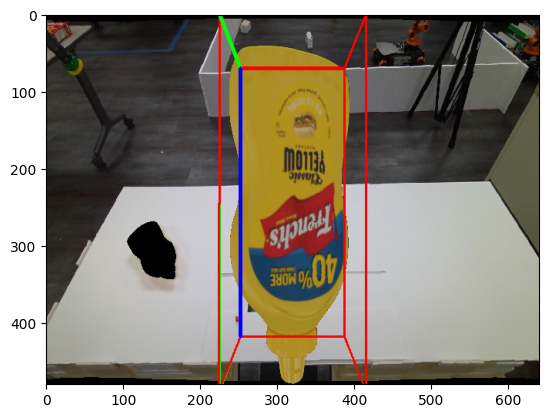

In [17]:
start, end = 15, 30
frame_idx = 20


def plot_video_of_rotations_over_time(
    rotations_6d, start_frame=0, end_frame=None, normalize=True, interval=30
):
    if normalize:
        rotations_6d = matrix_to_rotation_6d(rotation_6d_to_matrix(rotations_6d))
    rotations_6d = rotations_6d[:, start_frame:end_frame].cpu().numpy()

    frames = []
    for i in range(rotations_6d.shape[0]):
        if i % interval != 0:
            continue
        plt.plot(rotations_6d[i, :, 0], label="x")
        plt.plot(rotations_6d[i, :, 1], label="y")
        plt.plot(rotations_6d[i, :, 2], label="z")
        plt.plot(rotations_6d[i, :, 3], label="w")
        plt.plot(rotations_6d[i, :, 4], label="p")
        plt.plot(rotations_6d[i, :, 5], label="r")
        plt.legend()
        plt.savefig(f"rotation_frame_{i}.png")
        plt.close()
        frames.append(np.array(Image.open(f"rotation_frame_{i}.png").convert("RGB")))

    # Plot video at the end
    media.show_video(frames, fps=1)


def plot_bbox_over_time(gt_pose, estimated_poses, interval=15):
    black_frame = np.zeros((1, tracker.H, tracker.W, 3), dtype=np.uint8)
    bbox = dataset.bbox.float().cpu()
    K = torch.tensor(tracker.K).unsqueeze(0).float().cpu()
    gt_bbox_frame = overlay_bounding_box_on_video(
        black_frame,
        bbox,
        K,
        gt_pose[np.newaxis, :],
    )
    pose_indexes = np.arange(0, estimated_poses.shape[0], interval)
    # Repeat the gt_bbox_frame for the number of poses
    gt_bbox_frames = np.repeat(gt_bbox_frame, len(pose_indexes), axis=0)
    cam_Ks = K.repeat(len(pose_indexes), 1, 1)
    final_frame = overlay_bounding_box_on_video(
        gt_bbox_frames,
        bbox,
        cam_Ks,
        estimated_poses[pose_indexes].cpu(),
        color=(255, 0, 0),
    )

    mediapy.show_video(final_frame, fps=1)


plt.imshow(bbox_video[frame_idx])
plt.show()
plot_bbox_over_time(tracker.get_gt_pose(frame_idx), all_poses[:, frame_idx])
plot_video_of_rotations_over_time(
    all_rotations, normalize=True, start_frame=start, end_frame=end
)

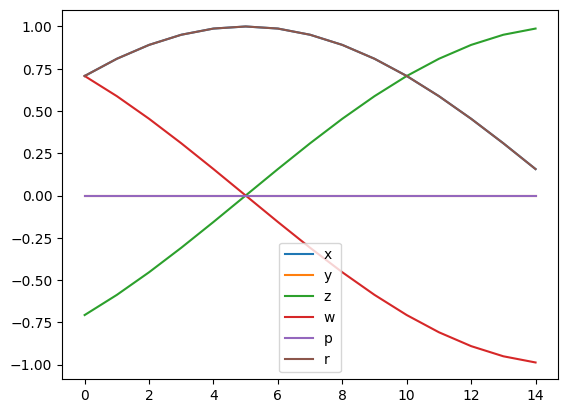

In [18]:
poses_r = torch.tensor(tracker.get_gt_poses()[:, :3, :3])
np_r6d = matrix_to_rotation_6d(poses_r).detach().cpu().numpy()
plt.plot(np_r6d[start:end, 0], label="x")
plt.plot(np_r6d[start:end, 1], label="y")
plt.plot(np_r6d[start:end, 2], label="z")
plt.plot(np_r6d[start:end, 3], label="w")
plt.plot(np_r6d[start:end, 4], label="p")
plt.plot(np_r6d[start:end, 5], label="r")
plt.legend()

Threshold: 0.019646325799497474
0.5834464043419267
0.0339359206609189


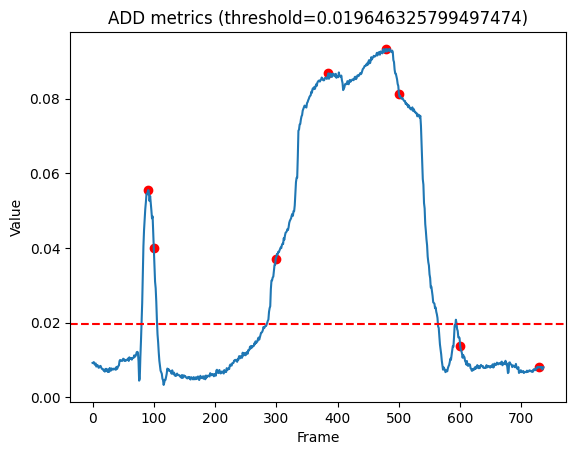

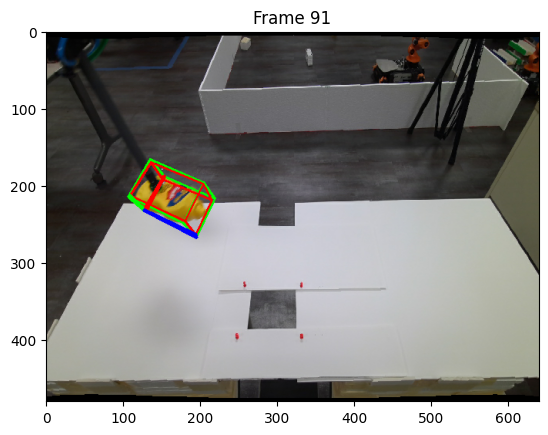

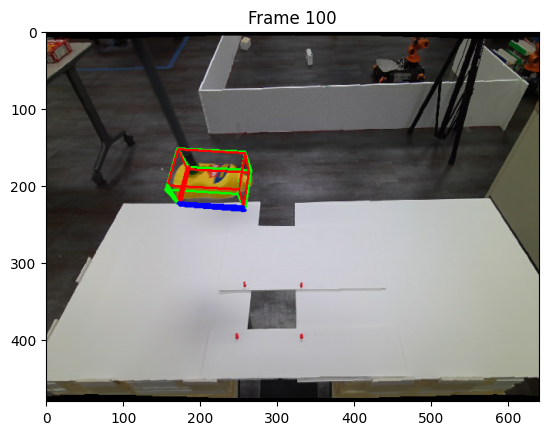

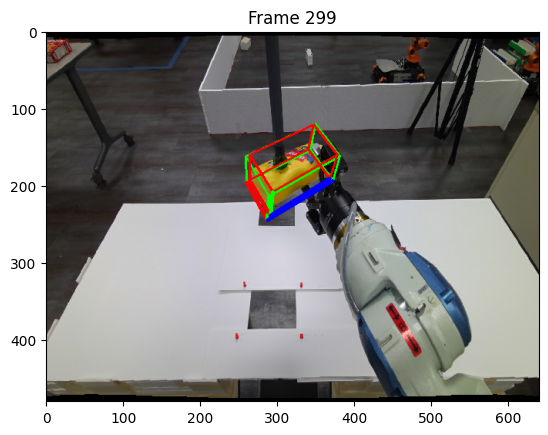

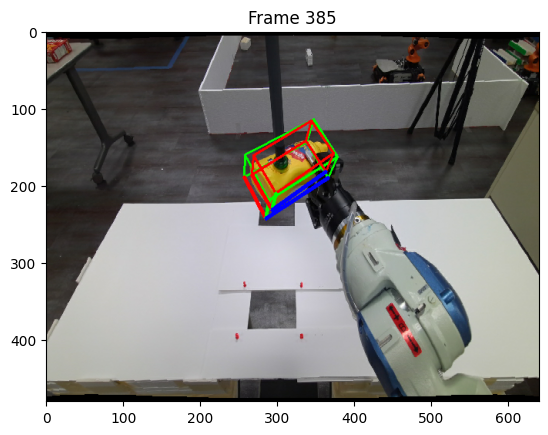

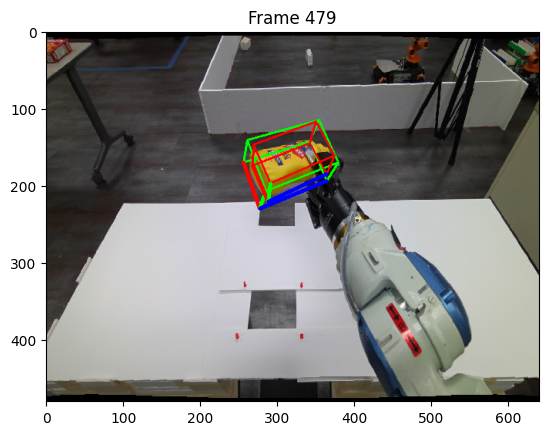

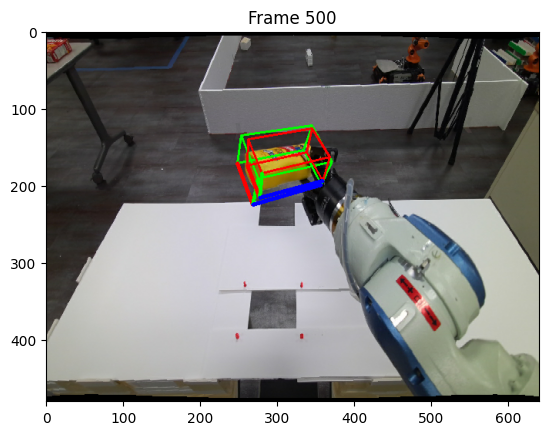

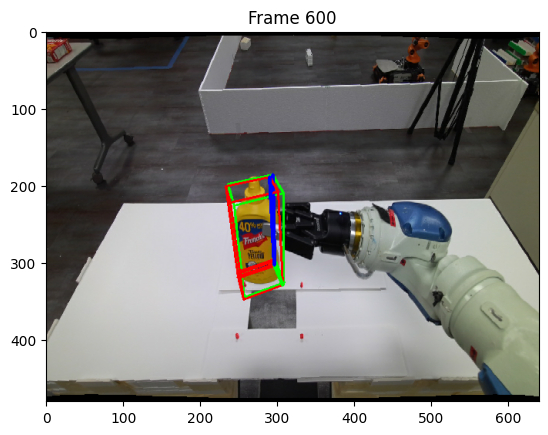

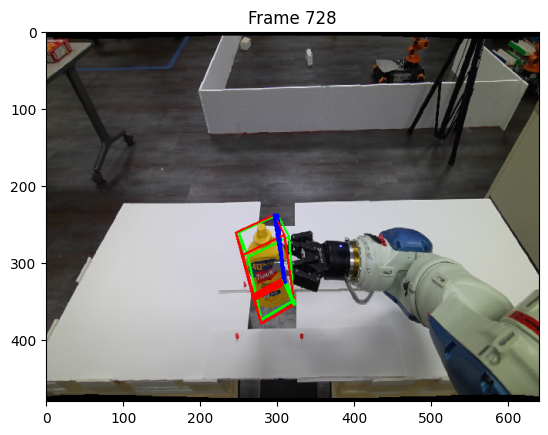

In [19]:
add_metrics = []
model_3D_pts = np.array(dataset.get_mesh().vertices)
percentage = 0.1
threshold = dataset.obj_diameter * percentage
print(f"Threshold: {threshold}")
for i in range(tracker.interpolation_steps, considered_limit):
    add_metrics.append(
        compute_add_metrics(
            model_3D_pts,
            dataset.obj_diameter,
            my_predicted_poses[i].detach().cpu().numpy(),
            tracker.get_gt_pose(i),
            percentage=percentage,
            return_error=True,
        )
    )
print(np.mean(np.array(add_metrics) < threshold, axis=0))
print(np.mean(np.array(add_metrics), axis=0))

# Divide video into chunks of 100 frames and find the max value in each chunk
add_metrics = np.array(add_metrics)
chunk_size = 100
max_values = []
max_indexes = []
for i in range(0, len(add_metrics), chunk_size):
    chunk = add_metrics[i : i + chunk_size]
    max_values.append(np.max(chunk))
    max_indexes.append(i + np.argmax(chunk))
max_values = np.array(max_values)
max_indexes = np.array(max_indexes)

plt.plot(add_metrics)
plt.title(f"ADD metrics (threshold={threshold})")
plt.xlabel("Frame")
plt.ylabel("Value")
# Plot points where max values occur
plt.scatter(max_indexes, max_values, color="r")
# Plot horizontal line at percentage
plt.axhline(threshold, color="r", linestyle="--")
plt.show()
for index in max_indexes:
    plt.imshow(bbox_video[tracker.interpolation_steps + index])
    plt.title(f"Frame {index}")
    plt.show()